In [71]:
import pandas as pd
from sqlalchemy import create_engine
# Update with your SQL Server details
server = r"DESKTOP-LGO4HD4\MSSQL"   # Your server name
database = "Customer360_DB"      # Your database name

# Create connection string
engine = create_engine(
    f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes",
    fast_executemany=True
)
pd.set_option('display.max_columns', None)

In [83]:
query = """
SELECT 
    Order_Date as ds,
    SUM(Sales) as y
FROM [Superstore 2025] 
GROUP BY Order_Date
ORDER BY ds
"""
df = pd.read_sql(query, engine)

In [84]:
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1131 non-null   datetime64[ns]
 1   y       1131 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.8 KB


In [ ]:
!pip install prophet


In [93]:
from prophet import Prophet

model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.fit(df)

# Create future dataframe (6 months forecast)
future = model.make_future_dataframe(periods=180)  # 6-month forecast
forecast = model.predict(future)

16:10:16 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing


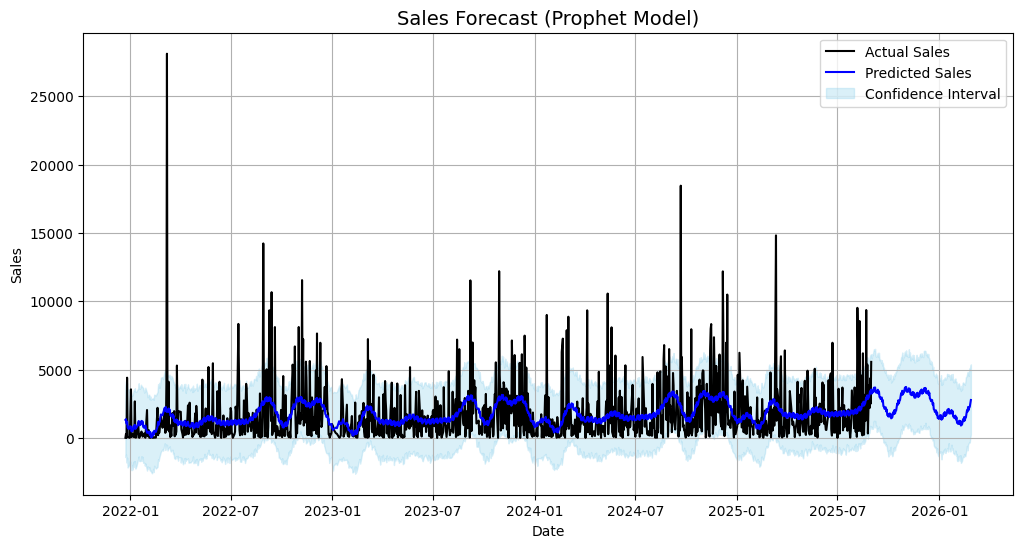

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Sales', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', color='blue')
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='skyblue',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('Sales Forecast (Prophet Model)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#### Push updated DataFrame back to SQL

In [95]:
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_result.columns = ['ForecastDate', 'PredictedSales', 'LowerBound', 'UpperBound']

forecast_result.to_sql('vw_Sales_Forecast', engine, if_exists='replace', index=False)

-1